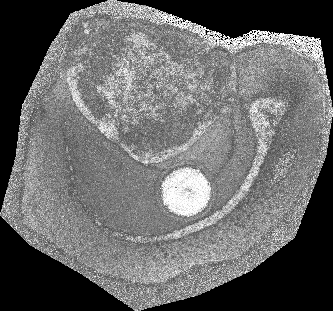

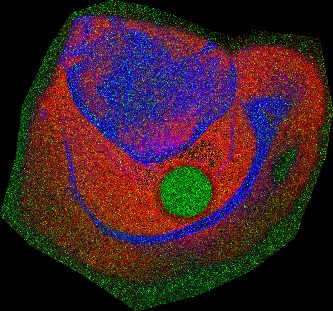

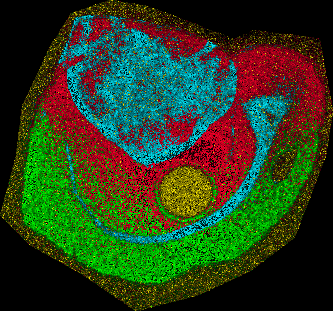

In [300]:
import numpy as np
import joblib
from sklearn.metrics.pairwise import cosine_similarity
from visualizations import get_colors, show_factorization_on_image
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax, create_pairwise_bilateral
import torch
from scipy.signal import savgol_filter

region = 3

W, H = np.load(f"{region}_w.npy"), np.load(f"{region}_h.npy")

model = joblib.load("kmeans.joblib")
centers = model.cluster_centers_
order = []
diffs = []
img = np.load(f"D:\\maldi\\{region}.npy")

for i in range(len(H)):
    sim = cosine_similarity(H[i, :][None, :], centers)[0, :]
    diffs.append(sim.max())
    order.append(sim.argmax())

NUM_COMPONENTS = 5
explanations = W.transpose().reshape(NUM_COMPONENTS, img.shape[0], img.shape[1])
#explanations = explanations / np.percentile(explanations, 99, axis=(0, 1, 2))

#explanations = explanations / explanations.sum(axis=(1, 2))[:, None, None]
explanations = explanations / np.percentile(explanations, 99, axis=(1, 2))[:, None, None]

explanations[order.index(4)] = 0

colors = get_colors(NUM_COMPONENTS)

colors_ordered = [colors[i] for i in order]    

certainty = explanations.max(axis=0) / (1e-7 + explanations.sum(axis=0))
display(Image.fromarray(np.uint8(255 * certainty)))

rgb = explanations[[0, 2, 3], :, :].copy().transpose((1, 2, 0))
display(Image.fromarray(np.uint8(255 * rgb)))


visualization = show_factorization_on_image(np.zeros(shape=((img.shape[0], img.shape[1], 3))),
                                            explanations,
                                            image_weight=0.0,
                                            colors=colors_ordered)

display(Image.fromarray(visualization))

ion = img.max(axis=(0,1))
indices = np.argsort(ion)[-30 : ]

In [59]:
import tqdm

# Inference without pair-wise terms
probs = np.float32(probs)
image = np.float32(img)
image = image / (1e-6 + np.sum(image, axis=-1)[:,:, None])
#image = image / (1e-6 + np.median(image, axis=-1)[:,:, None])
#image = image / (1e-6 + np.max(image, axis=-1)[:,:, None])

U = unary_from_softmax(probs.copy())  # note: num classes is first dim
d = dcrf.DenseCRF2D(probs.shape[2], probs.shape[1], 5)
d.setUnaryEnergy(U)

# Run inference for 10 iterations
#Q_unary = d.inference(10)
print(img.shape)
pairwise_energy = create_pairwise_bilateral(sdims=(3,3), schan=(0.01,), img=image[:, :, indices], chdim=2)
print(pairwise_energy.shape)
print("before")
d.addPairwiseEnergy(pairwise_energy, compat=20)  # `compat` is the "strength" of this potential.
print("after")

# This time, let's do inference in steps ourselves
# so that we can look at intermediate solutions
# as well as monitor KL-divergence, which indicates
# how well we have converged.
# PyDenseCRF also requires us to keep track of two
# temporary buffers it needs for computations.
Q, tmp1, tmp2 = d.startInference()
print("starting")

for _ in tqdm.tqdm(range(20)):
    d.stepInference(Q, tmp1, tmp2)
kl1 = d.klDivergence(Q) / (img.shape[0] * img.shape[1])
smoothed = np.float32(Q).reshape((5, img.shape[0], img.shape[1]))

#smoothed[order.index(4) == 0] = 0

map_soln1 = np.argmax(Q, axis=0).reshape((img.shape[0],img.shape[1]))
# for _ in range(20):
#     d.stepInference(Q, tmp1, tmp2)
# kl2 = d.klDivergence(Q) / (img.shape[1] * img.shape[2])
# map_soln2 = np.argmax(Q, axis=0).reshape((img.shape[1],img.shape[2]))
# for _ in range(50):
#     d.stepInference(Q, tmp1, tmp2)
# kl3 = d.klDivergence(Q) / (img.shape[1] * img.shape[2])
# map_soln3 = np.argmax(Q, axis=0).reshape((img.shape[1],img.shape[2]))

(311, 333, 1001)
(32, 103563)
before
after
starting


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.05it/s]


(311, 333)
(5, 311, 333)


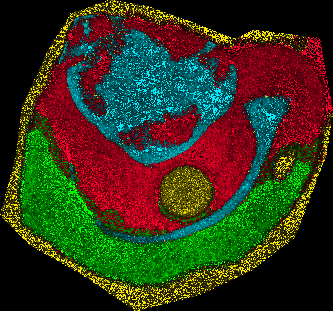

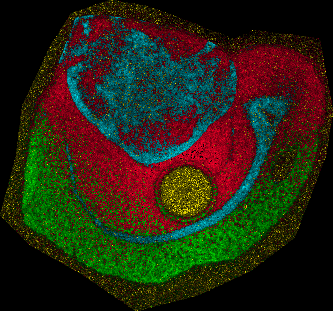

In [76]:
combined = explanations.copy() + smoothed
#combined[smoothed != smoothed.max(axis=0)] = 0
#combined = smoothed.copy()
#combined[order.index(4), :] = 0
mask = img.sum(axis=-1) == 0
print(mask.shape)
print(combined.shape)
combined[0][mask] = 0
combined[2][mask] = 0
combined[3][mask] = 0
combined[4][mask] = 0
visualization = show_factorization_on_image(np.zeros(shape=((img.shape[0], img.shape[1], 3))),
                                            combined,
                                            image_weight=0.0,
                                            colors=colors_ordered)
display(Image.fromarray(visualization))

visualization = show_factorization_on_image(np.zeros(shape=((img.shape[0], img.shape[1], 3))),
                                            explanations,
                                            image_weight=0.0,
                                            colors=colors_ordered)
display(Image.fromarray(visualization))

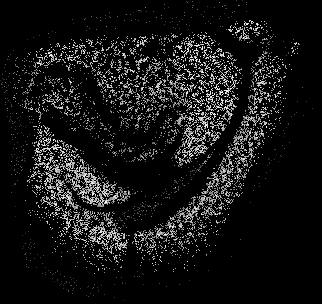

In [41]:
Image.fromarray(np.uint8(255 * probs[4, :, :]))

In [14]:
print(explanations.shape)

(5, 270, 301)


In [13]:
smoothed[1, :, :].max()

1.0

In [89]:
overall = []
for region in range(4):
    W, H = np.load(f"{region}_w.npy"), np.load(f"{region}_h.npy")
    strongest = np.argsort(H, axis=-1)[:, -100:]
    overall.extend(strongest)
overall = np.float32(overall).reshape(1, -1)
values, counts = np.unique(overall, return_counts=True)


ind = np.argpartition(-counts, kth=10)[:200]
print(list(np.int32(values[ind])))


[220, 207, 232, 227, 226, 225, 224, 223, 222, 221, 234, 208, 236, 206, 205, 204, 203, 202, 201, 200, 199, 233, 197, 235, 209, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 257, 198, 700, 196, 195, 194, 193, 192, 191, 190, 189, 188, 187, 186, 185, 144, 9, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 142, 137, 135, 128, 126, 122, 121, 120, 228, 229, 230, 231, 119, 112, 108, 107, 106, 104, 103, 102, 84, 77, 71, 62, 57, 46, 43, 39, 38, 33, 31, 30, 28, 25, 15, 12, 256, 10, 258, 259, 260, 261, 262, 264, 324, 585, 586, 587, 588, 1]


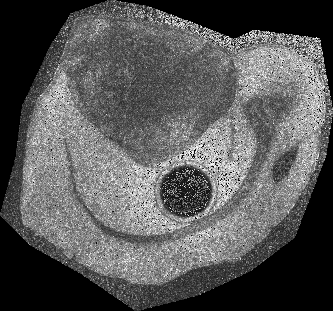

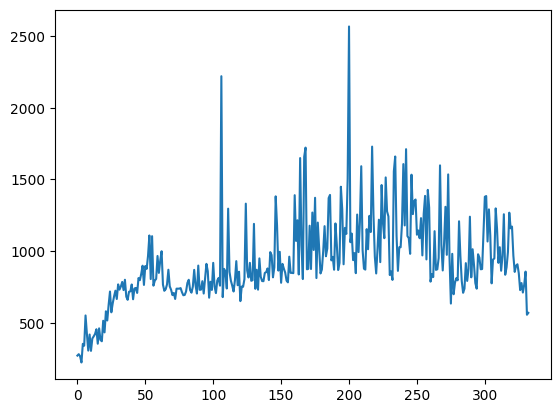

In [169]:
draw = np.max(img[:, :, 300 : ], axis=-1)

mean = img.max(axis=0)[:, 300 : ].max(axis=-1)
plt.plot(mean)

draw = draw / np.percentile(draw, 99)
Image.fromarray(np.uint8(255 * draw))

In [138]:
from maldi_nn.utils.data import *
from maldi_nn.spectrum import *

C:\Users\Jacob Gildenblat\AppData\Local\Temp\ipykernel_17288\1777139455.py:2: RuntimeWarning: divide by zero encountered in log2
  plt.plot(np.log2(img[100, 100, :]))
C:\Users\Jacob Gildenblat\AppData\Local\Temp\ipykernel_17288\1777139455.py:4: RuntimeWarning: divide by zero encountered in log2
  plt.plot(np.log2(img[100, 200, :]))


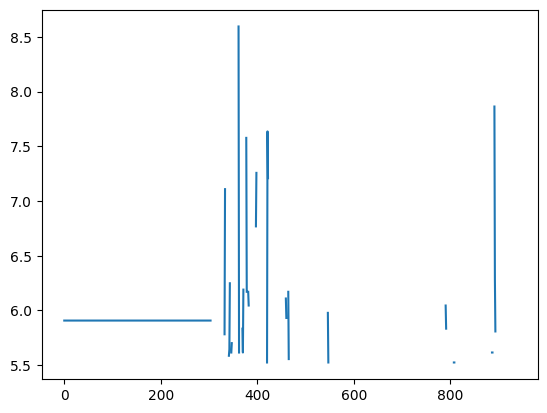

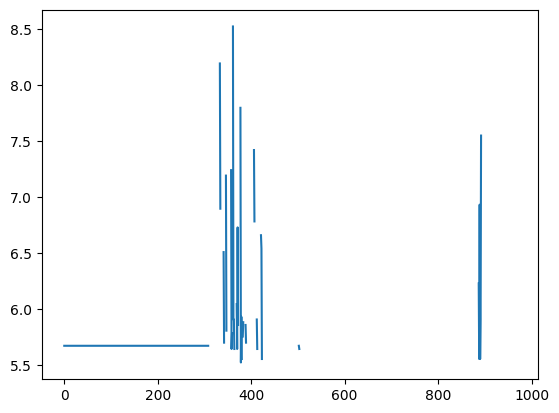

In [146]:
from matplotlib import pyplot as plt
plt.plot(np.log2(img[100, 100, :]))
plt.figure()
plt.plot(np.log2(img[100, 200, :]))

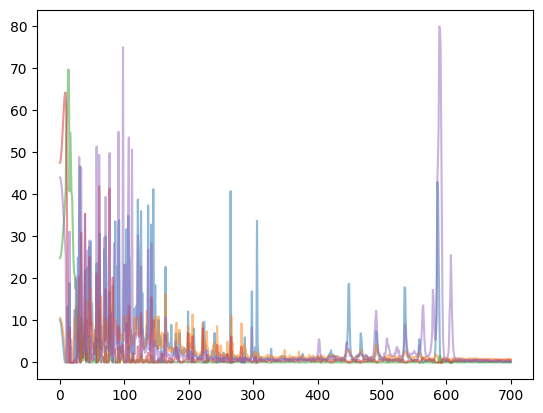

In [232]:
e = W.transpose().reshape(NUM_COMPONENTS, img.shape[0], img.shape[1])
plt.plot(H[0, :], alpha=0.5)
plt.plot(H[1, :], alpha=0.5)
plt.plot(H[2, :], alpha=0.5)
plt.plot(H[3, :], alpha=0.5)
plt.plot(H[4, :], alpha=0.5)

677 1186


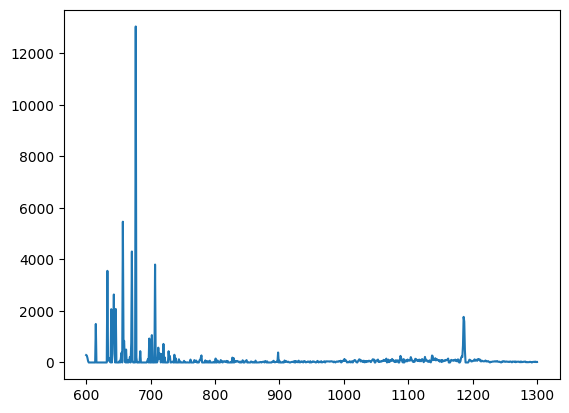

In [325]:
import joblib
results = joblib.load("results.joblib")
data = []
for r in results:
    w, h = r["components"]
    order = r["order"]

    relevant = h[order, :][[0, 2, 3], :]
    data.append(relevant)
data = np.float32(data)
data = data.reshape(-1, 701)
data = data.min(axis = 0)
plt.plot(range(600, 600 + len(data)), data)

data[:200].argmax() + 600
print(data[:200].argmax() + 600, data[400 : ].argmax() + 600 + 400)
